In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
data_raw = []
with open("trainset2.csv") as f:
    for i in range(70000):
        data_raw.append(eval(f.readline()))

In [3]:
dataset = np.array(data_raw)
images = dataset[:,:-1].astype("float32")
labels = dataset[:,-1].astype("uint8")

In [4]:
# Training Parameters
learning_rate = 0.001
num_steps = 10000
batch_size = 128

# Network Parameters
num_input = 64 # MNIST data input (img shape: 28*28)
num_classes = 4 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [14]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 8, 8, 1])

        # Convolution Layer with 32 filters and a kernel size of 3
        conv1 = tf.layers.conv2d(x, 32, 4, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        #conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        #conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [15]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [16]:
# Build the Estimator
tf.logging.set_verbosity(tf.logging.INFO)
model = tf.estimator.Estimator(model_fn=model_fn,model_dir="./mymodels/model3")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './mymodels/model3', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [33]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images}, y=labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=4000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mymodels/model3/model.ckpt-30000
INFO:tensorflow:Saving checkpoints for 30001 into ./mymodels/model3/model.ckpt.
INFO:tensorflow:loss = 0.9111126, step = 30001
INFO:tensorflow:global_step/sec: 46.1969
INFO:tensorflow:loss = 0.81463295, step = 30101 (2.166 sec)
INFO:tensorflow:global_step/sec: 45.9717
INFO:tensorflow:loss = 0.9182801, step = 30201 (2.175 sec)
INFO:tensorflow:global_step/sec: 46.2986
INFO:tensorflow:loss = 0.8761561, step = 30301 (2.160 sec)
INFO:tensorflow:global_step/sec: 46.0249
INFO:tensorflow:loss = 0.8133836, step = 30401 (2.173 sec)
INFO:tensorflow:global_step/sec: 46.1703
INFO:tensorflow:loss = 0.8868187, step = 30501 (2.166 sec)
INFO:tensorflow:global_step/sec: 46.1563
INFO:tensorflow:loss = 0.98359877, step = 30601 (2.166 sec)
INFO:tensorflow:global_step/sec: 46.4054
INFO:tensorflow:loss = 0.79388845, step = 30701 (2.155 sec)
INFO:tensorflow:global_step/sec: 43.0687
INFO:ten

In [34]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images}, y=labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-12-12-01:16:42
INFO:tensorflow:Restoring parameters from ./mymodels/model3/model.ckpt-34000
INFO:tensorflow:Finished evaluation at 2018-12-12-01:16:47
INFO:tensorflow:Saving dict for global step 34000: accuracy = 0.59594285, global_step = 34000, loss = 0.9065399


{'accuracy': 0.59594285, 'global_step': 34000, 'loss': 0.9065399}

INFO:tensorflow:Restoring parameters from ./mymodels/model.ckpt-10287129


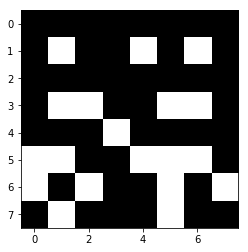

Model prediction: 0


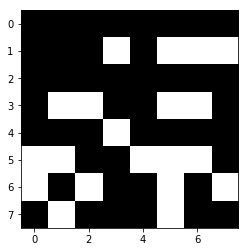

Model prediction: 3


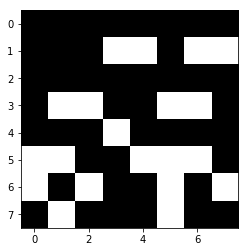

Model prediction: 0


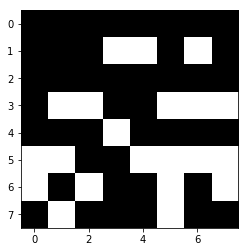

Model prediction: 3


In [13]:
# Predict single images
n_images = 4
# Get images from test set
test_images = images[1000:1000+n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [8, 8]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])